<p float="middle">
    <img src="image/CQF_gain_skills.gif" />
</p>


<br>
<center> <h3> ML Assignment Starting Demo and Q&A </h3> </center>
<center> <h3>Dr Richard Diamond, April 2020 </h3> </center>
<br>



# Predicing Asset Price Direction / Sign of Return


<br>

* **Foreword.** Remember that in addition to large-cap equities (eg, AMZN, GOOG) there are interesting industries (eg, Healthcare, Biotech) and other asset classes. You are more likely to find a sensible prediction scheme for commodity futures rather than a popular large cap.
<br><br>


* The way to organise the work: select your features (say 7-10 columns) and run Classifier.fit() on them. This is no different than running a regression.

<br>
Then you have results from different “regressions”. For each produce Area under ROC, Confusion Matrix, Transition Probabilities scatterplot (separate for each predicted Class label).

<br>

* One approach (but not limiting): run a classifier on all features given (cover different kinds of features) – your reasonable choices of time window for SMA, EMA, Momentum.  After that, throw out features not contributing and run on the reduced set.

[EMA example](https://user42.tuxfamily.org/chart/manual/Exponential-Moving-Average.html), smoothing factor $\alpha = 2/(N_{obs}+1)$.

<br>

* You may have situations of 'no move', especially if analysing a large market index -- the daily average return can be $O(0.04\%)$. No moves are improtant and create the need of multinomial classification.  But let's keep the study exercise clean exclude the very small 'no move' observations.

<br><br>

* OLS given for the illustration only.  Regressing on past returns (=lagged values) is the common model-free setup known as _Vector Autoregression_ (VAR). VAR does not work to predict daily return -- the order of error will be 150-200%. 

<br>

Second, OLS is **not** a valid regression model for binary dependent variable {0, 1}. To have non-linear link between dependent variable (such as binary 0,1  or Probability 0.01..0.99) the `Genearalized Linear Models' approach was theoretically developed and Logistic Regression.


-----

_Below was re-worked form [ML Elective for CQF]_ 04_stock_market_prediction.ipynb _Dr Yves Hilpisch_


In [2]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

### Getting Historical Data

In [3]:
# LOAD FROM EXCEL
# We have downloaded data previously in FP_EquitiesData notebook

data = pd.read_excel('data/EquitiesDataGOOG.xlsx', sheet_name="Sheet1", index_col=0, usecols=[0,5])
data.columns = ['price']  # Adj Close Price

In [4]:
data.head()

,price
Date,
2010-09-30,261.91
2010-10-01,261.83
2010-10-04,260.20
2010-10-05,268.11
2010-10-06,266.18


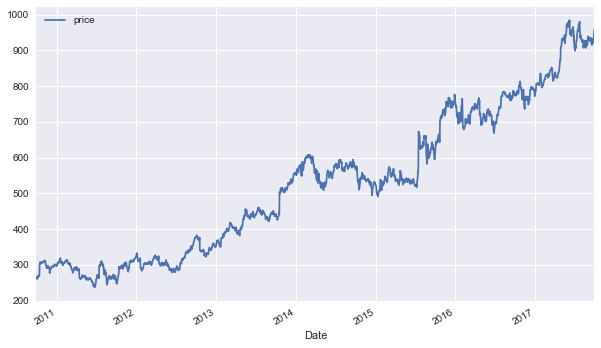

In [6]:
data.plot(figsize=(10, 6));

In [7]:
data['return'] = np.log(data / data.shift(1))

In [8]:
data.head()

,price,return
Date,,
2010-09-30,261.91,NaN
2010-10-01,261.83,-0.000305
2010-10-04,260.20,-0.006245
2010-10-05,268.11,0.029947
2010-10-06,266.18,-0.007225


In [9]:
lags = 5

cols = []
for lag in range(1, lags+1):
    col = 'ret_%d' % lag
    data[col] = data['return'].shift(lag)
    cols.append(col)
    
# Column indexation is from 0, so we effectively have range(1, 6) for returns
# CHECK NOT TO USE Return IN ACTUAL PREDICTION

In [10]:
data.head(10)

,price,return,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,,,
2010-09-30,261.91,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-01,261.83,-0.000305,NaN,NaN,NaN,NaN,NaN
2010-10-04,260.20,-0.006245,-0.000305,NaN,NaN,NaN,NaN
2010-10-05,268.11,0.029947,-0.006245,-0.000305,NaN,NaN,NaN
2010-10-06,266.18,-0.007225,0.029947,-0.006245,-0.000305,NaN,NaN
2010-10-07,264.02,-0.008148,-0.007225,0.029947,-0.006245,-0.000305,NaN
2010-10-08,267.17,0.011860,-0.008148,-0.007225,0.029947,-0.006245,-0.000305
2010-10-11,268.41,0.004631,0.011860,-0.008148,-0.007225,0.029947,-0.006245
2010-10-12,269.68,0.004720,0.004631,0.011860,-0.008148,-0.007225,0.029947


In [11]:
data.dropna(inplace=True)

data = data.drop(columns="price")

data['return_sign'] = np.sign(data['return'].values)


data_adv = data.copy() #save a copy for advanced methods (classifiers), as compared to the linear regression

In [12]:
data.head()

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign
Date,,,,,,,
2010-10-08,0.011860,-0.008148,-0.007225,0.029947,-0.006245,-0.000305,1.0
2010-10-11,0.004631,0.011860,-0.008148,-0.007225,0.029947,-0.006245,1.0
2010-10-12,0.004720,0.004631,0.011860,-0.008148,-0.007225,0.029947,1.0
2010-10-13,0.003553,0.004720,0.004631,0.011860,-0.008148,-0.007225,1.0
2010-10-14,-0.004370,0.003553,0.004720,0.004631,0.011860,-0.008148,-1.0


### OLS Regression - illustration only

**NOTE** OLS is **not** a valid regression model for binary dependent variable {0, 1}. Below work is illustration-only -- do not run OLS in your assignments and projects.

In [13]:
# Regression from NUMPY library
reg_coef = np.linalg.lstsq(data[cols].values, data['return_sign'])[0]

# PREFER delegates to use STATSMOTELS
#import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [14]:
reg_coef

array([ 1.13255353,  0.34409898, -2.87238464, -0.40975749, -1.38671844])

In [15]:
data['ols_pred'] = np.sign(np.dot(data[cols].values, reg_coef)) #dot product

In [16]:
data.head(15)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,ols_pred
Date,,,,,,,,
2010-10-08,0.011860,-0.008148,-0.007225,0.029947,-0.006245,-0.000305,1.0,-1.0
2010-10-11,0.004631,0.011860,-0.008148,-0.007225,0.029947,-0.006245,1.0,1.0
2010-10-12,0.004720,0.004631,0.011860,-0.008148,-0.007225,0.029947,1.0,-1.0
2010-10-13,0.003553,0.004720,0.004631,0.011860,-0.008148,-0.007225,1.0,-1.0
2010-10-14,-0.004370,0.003553,0.004720,0.004631,0.011860,-0.008148,-1.0,-1.0
2010-10-15,0.106028,-0.004370,0.003553,0.004720,0.004631,0.011860,1.0,-1.0
2010-10-18,0.026677,0.106028,-0.004370,0.003553,0.004720,0.004631,1.0,1.0
2010-10-19,-0.016119,0.026677,0.106028,-0.004370,0.003553,0.004720,-1.0,1.0
2010-10-20,0.000231,-0.016119,0.026677,0.106028,-0.004370,0.003553,1.0,-1.0


#### Count number of predicted moves UP and DOWN

In [17]:

data['ols_pred'].value_counts()

#c.value_counts()[1] / (c.value_counts().sum()) #We were UP this percentage of observations/days

-1.0    938
 1.0    819
Name: ols_pred, dtype: int64

The probelm will transpire: the model is likely to be bad at predicting negative returns, there are a lot of **false negatives** with -1.0 label. The asset path is downwards and downwards because of overpredicted negative returns.

YH code "fudges" backtesting plot because correctly predicted negative signs give positive moves up (which gives appearance of feasible but a wrong path).

---

### Backtesting of Daily Rebalancing


NEGATIVE 'ols_pred' and 'return' had NEGATIVE sign = POSITIVE P\&L

NEGATIVE 'ols_pred' but 'return' had POSITIVE sign (moved up) = NEGATIVE P\&L, loss

POSITIVE 'ols_pred' but 'return' had NEGATIVE sign = NEGATIVE P\&L, loss

POSITIVE 'ols_pred' and 'return' had POSITIVE sign (moved up) = POSITIVE P\&L

In [56]:
data['ols_pred_backtest'] = data['return'] * data['ols_pred']

**This multiplication represents a sequence of daily bets assume \$100, based on the sign (up/down move) predicted from past returns (lagged returns).**

<br>

The actual return that realises today $t$, is \% P\&L that one makes (loses) on the bet of \$100, for example if return today is POSITIVE 0.018 and predcited sign was POSITIVE, then P\&L is 1.18%.

------

<br>

Assume we want to have more model-like prediction. Then, we will use standard deviation, which gives some measure of randomness.

* We use std dev from the dataset but that can be estimated from any prevoius holdout period/window. Such backtesting requires past data but not regular daily update of return -- the latter is historical backtesting.

* $\pm 0.7$ of the standard deviation translates into betting \$70 of std deviation -- the actual P\&L which would still depend on actual return. But we can plot cumulative P\&L from 'ols_pred_move' to see if matches with the asset path. It also is possible to do P\&L Attribution test on such std dev model:

<br>

'ols_pred_move' is in effect, our **Theoretical P\&L**

<br>

'return' is the **Actual P\&L**

<br>

* Why z-score of $\pm 0.7$? This is because empirical asset returns are not well-Normal and between $\pm 2$ standard deviation, but their density/histogram is high-peak (high mode). If you standardise returns $ z_t = (r_t - \mu) / \sigma$ the histogram of $z_t$ will have bars within  $\pm 0.7$.


* Instead of $\pm 0.7$ and to provide negative outcomes, we can use simulated values of Random Normal $\phi$ which can be positive or negative.


In [58]:
stdev = data['return'].std()  #from a whole dataset but you can introduce Train/Test split

data['ols_pred_move'] = 0.7 * stdev * (data['ols_pred'])
data['ols_pred_move_FUDGED'] = 0.7 * stdev * ( - data['ols_pred']) #PREDICTION INVERTED!

data['ols_pred_ABSOLUTE'] = abs(data['return']) * data['ols_pred']

In [53]:
data.head(20)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,ols_pred,ols_pred_move_INVERTED,ols_pred_return,ols_pred_move,ols_pred_return_abs,ols_pred_move_FUDGED
Date,,,,,,,,,,,,,
2010-10-08,0.011860,-0.008148,-0.007225,0.029947,-0.006245,-0.000305,1.0,-1.0,0.010402,-0.011860,-0.010402,-0.011860,0.010402
2010-10-11,0.004631,0.011860,-0.008148,-0.007225,0.029947,-0.006245,1.0,1.0,-0.010402,0.004631,0.010402,0.004631,-0.010402
2010-10-12,0.004720,0.004631,0.011860,-0.008148,-0.007225,0.029947,1.0,-1.0,0.010402,-0.004720,-0.010402,-0.004720,0.010402
2010-10-13,0.003553,0.004720,0.004631,0.011860,-0.008148,-0.007225,1.0,-1.0,0.010402,-0.003553,-0.010402,-0.003553,0.010402
2010-10-14,-0.004370,0.003553,0.004720,0.004631,0.011860,-0.008148,-1.0,-1.0,0.010402,0.004370,-0.010402,-0.004370,0.010402
2010-10-15,0.106028,-0.004370,0.003553,0.004720,0.004631,0.011860,1.0,-1.0,0.010402,-0.106028,-0.010402,-0.106028,0.010402
2010-10-18,0.026677,0.106028,-0.004370,0.003553,0.004720,0.004631,1.0,1.0,-0.010402,0.026677,0.010402,0.026677,-0.010402
2010-10-19,-0.016119,0.026677,0.106028,-0.004370,0.003553,0.004720,-1.0,1.0,-0.010402,-0.016119,0.010402,0.016119,-0.010402
2010-10-20,0.000231,-0.016119,0.026677,0.106028,-0.004370,0.003553,1.0,-1.0,0.010402,-0.000231,-0.010402,-0.000231,0.010402


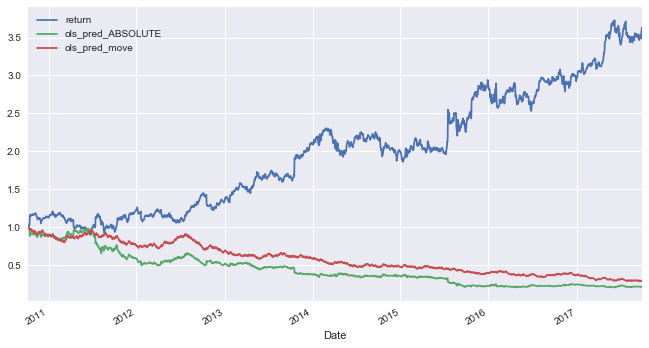

In [59]:
data[['return', 'ols_pred_ABSOLUTE', 'ols_pred_move']].cumsum().apply(np.exp).plot(figsize=(11, 6));

* 'ols_pred_ABSOLUTE' and 'ols_pred_move' from std dev do not reproduce the asset price path at all. This plot reveals the poor quality of prediction.  **FINDING:** correct negatives plus false negatives make for a bad prediction. OLS seems to produce a lot of negative predicitons which do not realise. 


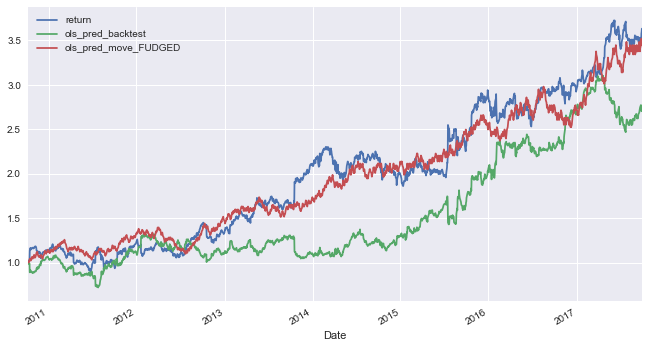

In [60]:
data[['return', 'ols_pred_backtest', 'ols_pred_move_FUDGED']].cumsum().apply(np.exp).plot(figsize=(11, 6));

**DISCUSSION QUESTIONS** 

* Why 'pred_return' does not match the asset path ('return').  ANSWER: because this is cumulative return/asset price path with predicted sign of return (each day).  We basically did **worse** than simply investing \$100 and keeping the position (without daily re-betting).

<br>

* FUDGED inverted sign of OLS prediction worked better at reproducing the asset price path.  This is?  ANSWER: this is likely because of cancelled false negatives, i.e., if OLS produces a lot of negative predicitons which do not realise (as said above).

<br>

* Remember OLS is **not** a valid regression model for binary dependent variable {0, 1}. **Do not** run OLS in your assignments and projects.

-----

## Logistic Regression (Support Vectors Classifier in parallel)

In [32]:
from sklearn import linear_model 

from sklearn.svm import SVC  #you can import ANY OTHER CLASSIFIER and proceed in the same way

In [33]:
lm = linear_model.LogisticRegression(C = 1e5) 

svcm = SVC(C= 1e5, probability=True) 

As your vary penalty/hyparameter -- what happens to your coefficients for features? 

What happens to accuracy and transition probabilities?


* **Logistic Classifier**

C= 1e5 is nearly no L2 Penalty because parater set in inverse.

Try strong penalisation C=1 or 0.5 (or 0.01 for mild penalty. 

What about L1 Penalty?

* **SVM Classifier**

C= 1e5 NOT inverse for Support Vector Machines. This is Hard Margins.

Try Soft Margins which supposed to work better on time series.

Try smaller number of features -- SVM might work better


**Following ML Lab, we know that we have to consider the accuracy and pattern of prediction _within each class_. 

**TO DO** Use the tools of **confusion matrix** and **area under the ROC curve** to investigate.

In [34]:
# we use data_adv copy of the dataset

lm.fit(data_adv[cols], data_adv['return_sign'])

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [35]:

svcm.fit(data_adv[cols], data_adv['return_sign'])

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
data_adv['logit_pred'] = lm.predict(data_adv[cols])
data_adv['logit_pred_backtest'] = data_adv['return'] * data_adv['logit_pred']

data_adv['svm_pred'] = svcm.predict(data_adv[cols])
data_adv['svm_pred_backtest'] = data_adv['return'] * data_adv['svm_pred'] 

In [62]:
data_adv.head(20)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,logit_pred,logit_pred_return,svm_pred,svm_pred_return
Date,,,,,,,,,,,
2010-10-08,0.011860,-0.008148,-0.007225,0.029947,-0.006245,-0.000305,1.0,-1.0,-0.011860,1.0,0.011860
2010-10-11,0.004631,0.011860,-0.008148,-0.007225,0.029947,-0.006245,1.0,1.0,0.004631,1.0,0.004631
2010-10-12,0.004720,0.004631,0.011860,-0.008148,-0.007225,0.029947,1.0,1.0,0.004720,1.0,0.004720
2010-10-13,0.003553,0.004720,0.004631,0.011860,-0.008148,-0.007225,1.0,1.0,0.003553,1.0,0.003553
2010-10-14,-0.004370,0.003553,0.004720,0.004631,0.011860,-0.008148,-1.0,1.0,0.004370,1.0,0.004370
2010-10-15,0.106028,-0.004370,0.003553,0.004720,0.004631,0.011860,1.0,1.0,0.106028,1.0,0.106028
2010-10-18,0.026677,0.106028,-0.004370,0.003553,0.004720,0.004631,1.0,1.0,0.026677,-1.0,-0.026677
2010-10-19,-0.016119,0.026677,0.106028,-0.004370,0.003553,0.004720,-1.0,1.0,0.016119,1.0,0.016119
2010-10-20,0.000231,-0.016119,0.026677,0.106028,-0.004370,0.003553,1.0,-1.0,-0.000231,-1.0,-0.000231


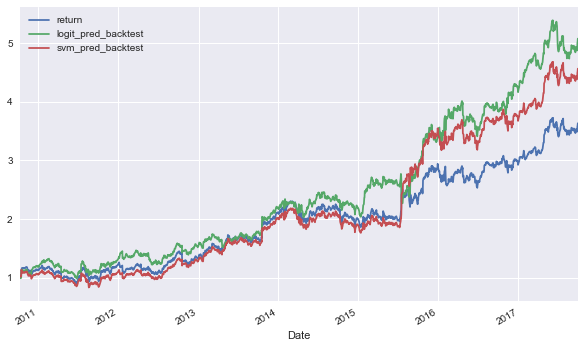

In [65]:
data_adv[['return', 'logit_pred_backtest', 'svm_pred_backtest']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
# Instead of 0.7 we should use simulated Normal Random Variable
#or we end up with just gives exponentially rising plots, no down moves predicted

#data_adv['logit_pred_move'] = 0.7 * stdev * (data_adv['logit_pred'])
#data_adv['svm_pred_move'] = 0.7 * stdev * (data_adv['svm_pred'])

**NEXT STEPS**

* Investigate the prediction Recall egative moves. Next step is categorising large negative moves into third class label $\{1,0, -1\}$ but that brings us to multinomial prediction.

* SVM appeared to be the best method but will it work in the situation of multiple different features?

-----

**END OF DEMONSTRATION**
